<a href="https://colab.research.google.com/github/thepbordin/Find-water-AI-builders-project/blob/main/finewater_pytorch/Water_unet_pytroch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sementic Segmentation ด้วย Pytorch

โปรเจ็คนี้ถูกสร้างขึ้นเพื่อเป็นตัวอย่างในการสอนการใช้งาน Pytorch-SemanticSegmentation
 ของค่าย [AI-Builders](https://ai-builders.github.io/)

โดยใช้ชุดข้อมูลจาก Kaggle [Satellite Images of Water Bodies](https://www.kaggle.com/franciscoescobar/satellite-images-of-water-bodies)

จัดทำและเรียบเรียงโดย [Peemai](https://github.com/19xx47), [HRNPH](https://github.com/HRNPH) และ [Thepbordin](https://github.com/thepbordin) AI Builders Gen 2 (2022)

#1. Install Libraries

In [1]:
# Core Library
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
# จัดการไฟล์(ย้าย, copy, etc...)
import os
import glob
 # อ่าน/แก้ไข/แสดงผล รูปภาพ
import cv2
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Dataloader และตัวช่วยทำ Augmentation
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
# ใช้สร้างแถบโหลด
import tqdm

ตั้งค่า Seed เพื่อควบคุมการสุ่ม 


`ถ้า Seed เป็นเลขเดิม การสุ่มก็จะได้ผลลัพธ์คงเดิม`

In [2]:
# ตั้งค่า  Random Seed เพื่อควบคุมการสุ่ม
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 2. Data Preparation เตรียมพร้อมข้อมูล

## 2.1 Download **Satellite Images of Water Bodies** Dataset

จริงๆแล้ว Dataset จาก Kaggle สามารถดาวน์โหลดผ่าน Kaggle API ได้ 

แต่ต้องมีการ Setup เล็กน้อย ดั้งนั้นเพื่อความสะดวกเราจึงโหลดจาก Google Drive

In [3]:
# # ดึงชุดข้อมูล satellite-images-of-water-bodies มาจาก Kaggle
# !pip install kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies

In [4]:
!pip install gdown -q # library สำหรับดาวน์โหลดไฟล์ Google Drive
!gdown "https://drive.google.com/u/1/uc?id=1dWV4b1eKarBHwaYNyrdsAZ-FLSwrgF7S&export=download" 
!unzip -q -u "/content/Satellite Images of Water Bodies" -d "/content/" # แตกไฟล์
#      ^  -q(quite) เพื่อไม่ให้แสดง logs จะได้ไม่รกจอ

Downloading...
From: https://drive.google.com/u/1/uc?id=1dWV4b1eKarBHwaYNyrdsAZ-FLSwrgF7S&export=download
To: /content/Satellite Images of Water Bodies.zip
100% 259M/259M [00:01<00:00, 258MB/s]


In [5]:
X = sorted(glob.glob('/content/Water Bodies Dataset/Images/*')) # เรียงรายชื่อไฟล์แบบ Alphabetically
Y = sorted(glob.glob('/content/Water Bodies Dataset/Masks/*')) # เรียงรายชื่อไฟล์แบบ Alphabetically

In [6]:
# เช็คจำนวนข้อมูล (ควรจะเท่ากัน)
len(X)
len(Y)

2841

## 2.2 Train/Valid Split
แบ่งข้อมูลเป็น Training Set และ Validation Set ดังนี้
*   แบ่งให้ 1988 ข้อมูลแรกเป็น Training Set
*   แบ่งให้ข้อมูล 1988 ข้อมูลหลังเป็น Validation Set



In [7]:
# ใช้แค่ 1988 ตัวแรก ในการเทรน(:1988)
train_X = X[:1988]
train_Y = Y[:1988]
# อีก 1988 ตัวหลังในการ valid(1988:)
valid_X = X[1988:]
valid_Y = Y[1988:]

In [8]:
len(train_X)

1988

In [9]:
len(train_Y)

1988

In [10]:
len(valid_X)

853

## 2.3 สร้าง Dataloader
เพื่อโหลดข้อมูลเข้า Model ทีละ Batch และยังมีการ Pre-Processing ข้อมูลอย่างการ Resize ขนาดภาพ



In [11]:
size = (256, 256) # Size input (ขนาดรูปภาพ)

In [12]:
# Dataloader
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = transforms.Resize(size) #Resize รูปภาพ

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        img = self.transform(img)
        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = Image.open(self.masks_path[idx]).convert('L')
        mask = self.transform(mask)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

In [13]:
# เอาข้อมูลเข้า DataLoader (ไปอ่าน Class LoadData ด้านบน)
train_dataset = LoadData(train_X, train_Y)
valid_dataset = LoadData(valid_X, valid_Y)

In [14]:
img, mask = train_dataset[5] # หยิบภาพ และ Mask ที่ index 5

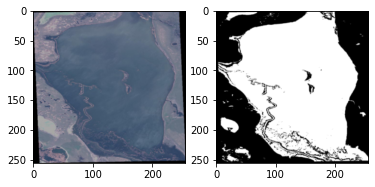

In [15]:
# มาลองแสดงผลดู
f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))

In [16]:
img.shape
torch.Size([3, 256, 256])

torch.Size([3, 256, 256])

#3. Modeling
โค้ดของ Model ที่เราสามารถปรับได้อย่างตามใจชอบ นี่ล่ะที่เป็นข้อดีของ Pytorch

## 3.1 Architecture

In [17]:
class conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()
    
    def forward(self, images):
        x = self.conv1(images)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

In [18]:
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = conv(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2,2))

    def forward(self, images):
        x = self.conv(images)
        p = self.pool(x)

        return x, p

In [19]:
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv = conv(out_channels * 2, out_channels)

    def forward(self, images, prev):
        x = self.upconv(images)
        x = torch.cat([x, prev], axis=1)
        x = self.conv(x)

        return x

In [20]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder(3, 64)
        self.e2 = encoder(64, 128)
        self.e3 = encoder(128, 256)
        self.e4 = encoder(256, 512)

        self.b = conv(512, 1024)

        self.d1 = decoder(1024, 512)
        self.d2 = decoder(512, 256)
        self.d3 = decoder(256, 128)
        self.d4 = decoder(128, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, images):
        x1, p1 = self.e1(images)
        x2, p2 = self.e2(p1)
        x3, p3 = self.e3(p2)
        x4, p4 = self.e4(p3)

        b = self.b(p4)
        
        d1 = self.d1(b, x4)
        d2 = self.d2(d1, x3)
        d3 = self.d3(d2, x2)
        d4 = self.d4(d3, x1)

        output_mask = self.output(d4)
        output_mask = torch.sigmoid(output_mask)

        return output_mask      

## 3.2 Training Settings

In [21]:
batch_size = 8
num_epochs = 20
lr = 1e-4 # Learning Rate
checkpoint_path = "./checkpoint.pth"

In [22]:
device = torch.device('cuda')
model = UNet()
model = model.to(device)

กำหนด Dataloader

In [23]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
)

กำหนด Loss Function

In [24]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        dice_loss = 1 - dice_score
        loss = torch.nn.BCELoss()
        BCE = loss(inputs, targets)
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = DiceBCELoss()

## 3.3 Training loop & Evaluator

สร้าง Training Loop

In [26]:
def train_model(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

สร้าง Evaluator

In [27]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
#             x,y=x.type(torch.FloatTensor),y.type(torch.FloatTensor)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

## 3.4 Start Training!
เมื่อทุกอย่างพร้อมแล้วก็เริ่มเทรนได้เลย!
เริ่ม Train Model!

ถ้าต้องการปรับตั้งค่าต่างๆก็สามารถไปปรับได้ที่ `3.2 Training Settings`

In [28]:
train = []
valid = []

best_valid_loss = float("inf")

for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train.append(train_loss)
        valid.append(valid_loss)        
        
        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        data_str = f'Epoch: {epoch+1:02}\n'
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
        print(data_str)

Valid loss improved from inf to 0.7621. Saving checkpoint: ./checkpoint.pth
Epoch: 01
	Train Loss: 0.882
	 Val. Loss: 0.762

Valid loss improved from 0.7621 to 0.7015. Saving checkpoint: ./checkpoint.pth
Epoch: 02
	Train Loss: 0.767
	 Val. Loss: 0.701

Valid loss improved from 0.7015 to 0.6597. Saving checkpoint: ./checkpoint.pth
Epoch: 03
	Train Loss: 0.719
	 Val. Loss: 0.660

Valid loss improved from 0.6597 to 0.5975. Saving checkpoint: ./checkpoint.pth
Epoch: 04
	Train Loss: 0.672
	 Val. Loss: 0.597

Valid loss improved from 0.5975 to 0.5587. Saving checkpoint: ./checkpoint.pth
Epoch: 05
	Train Loss: 0.635
	 Val. Loss: 0.559

Epoch: 06
	Train Loss: 0.624
	 Val. Loss: 0.564

Valid loss improved from 0.5587 to 0.5165. Saving checkpoint: ./checkpoint.pth
Epoch: 07
	Train Loss: 0.592
	 Val. Loss: 0.517

Valid loss improved from 0.5165 to 0.4961. Saving checkpoint: ./checkpoint.pth
Epoch: 08
	Train Loss: 0.562
	 Val. Loss: 0.496

Epoch: 09
	Train Loss: 0.560
	 Val. Loss: 0.529

Epoch: 10

### Plotting training loss / validation loss

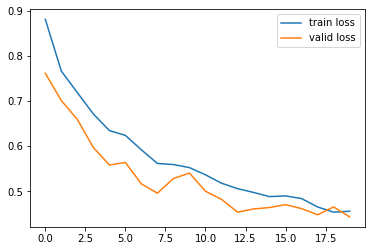

In [29]:
plt.plot(range(0,20), train, label='train loss')
plt.plot(range(0,20), valid, label='valid loss')
plt.legend()

# Evaluation

ทดสอบ model ด้วย Validation Set
และดู Metrics 

*   BCE-Dice Loss
*   Dice Score 



Save Model


In [30]:
torch.save(model.state_dict(), "water.pt")
the_model = torch.load("water.pt")

In [31]:
m = UNet()
m.load_state_dict(torch.load(checkpoint_path))
m = m.to(device)

### Show model Prediction on Valid set

<Figure size 2160x576 with 0 Axes>

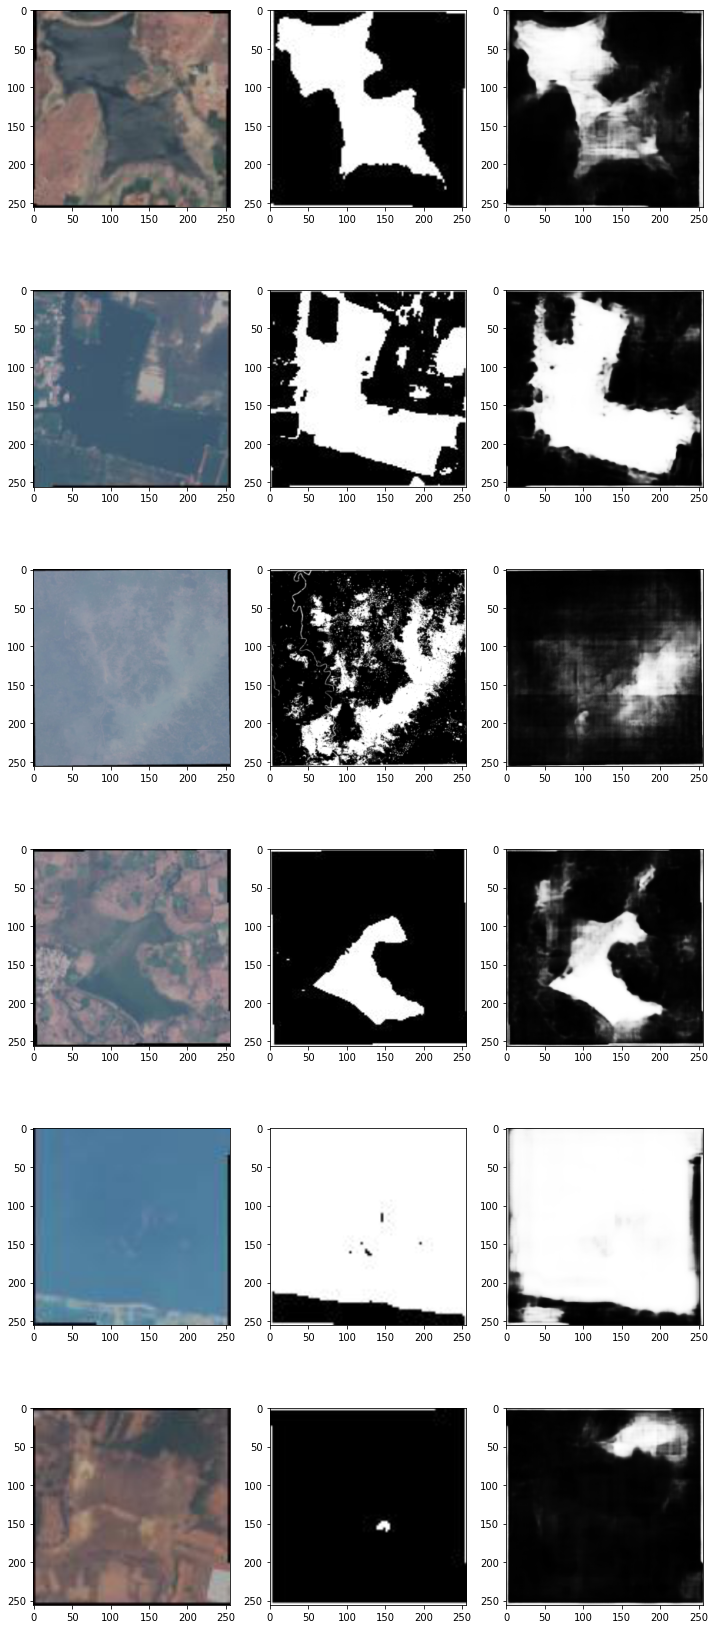

In [32]:
transform = transforms.ToPILImage()
pred = []
for x, y in valid_loader:
    image0 = transform(x[0])
    image1 = transform(x[1])
    image2 = transform(x[2])
    image3 = transform(x[3])
    image4 = transform(x[4])
    image5 = transform(x[5])

    x = x.to(device, dtype=torch.float32)
    y = y.to(device, dtype=torch.float32)
    
    y_pred = m(x)
    img = y_pred.cpu().detach().numpy()
    plt.figure(figsize=(30,8))

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(6,3) 
    f.set_size_inches(12, 30, forward=True)
    axarr[0,0].imshow(image0)
    axarr[0,1].imshow(np.squeeze(y.cpu().detach().numpy())[0], cmap='gray')
    axarr[0,2].imshow(np.squeeze(img)[0], cmap='gray')
    
    axarr[1,0].imshow(image1)
    axarr[1,1].imshow(np.squeeze(y.cpu().detach().numpy())[1], cmap='gray')
    axarr[1,2].imshow(np.squeeze(img)[1], cmap='gray')
    
    axarr[5,0].imshow(image2)
    axarr[5,1].imshow(np.squeeze(y.cpu().detach().numpy())[2], cmap='gray')
    axarr[5,2].imshow(np.squeeze(img)[2], cmap='gray')
    
    axarr[2,0].imshow(image3)
    axarr[2,1].imshow(np.squeeze(y.cpu().detach().numpy())[3], cmap='gray')
    axarr[2,2].imshow(np.squeeze(img)[3], cmap='gray')
    
    axarr[3,0].imshow(image4)
    axarr[3,1].imshow(np.squeeze(y.cpu().detach().numpy())[4], cmap='gray')
    axarr[3,2].imshow(np.squeeze(img)[4], cmap='gray')
    
    axarr[4,0].imshow(image5)
    axarr[4,1].imshow(np.squeeze(y.cpu().detach().numpy())[5], cmap='gray')
    axarr[4,2].imshow(np.squeeze(img)[5], cmap='gray')
    break

### Metric BCE-Dice Loss

In [33]:
Dice_BCE = evaluate(m, valid_loader, loss_fn, device)
Dice_BCE

0.44222392072187405

### Metric Dice Score

In [34]:
def dice_score(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
#             x,y=x.type(torch.FloatTensor),y.type(torch.FloatTensor)

            y_pred = model(x)
            inputs = y_pred.view(-1)
            targets = y.view(-1)
            smooth = 1

            intersection = (inputs * targets).sum()
            dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
            epoch_loss += dice_score

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [35]:
diceScore = dice_score(m, valid_loader, loss_fn, device)

In [36]:
diceScore.item()

0.8038080930709839